# Capstone 2: Exploratory Data Analysis
<b>PROJECT GOAL</b><br>
The overall goal of this project is to understand and predict a time series on delinquency rate (response variable) for lease contracts originated by U.S. banks.  Time series for several predictor (exogenous) variables will be included in an attempt to identify economic variables that may help explain and thus predict future lease delinquency rates.<br>

<b>DATA</b><br>
<i>all series have been converted to quarterly data as of each calendar quarter end</i><br>

<i>response variable</i><br>
'delinq' = Lease Delinquency Rate, all banks; www.federalreserve.gov/datadownload/)<br><br>
<i>predictor (exogenous) variables (features)</i><br>
'ls_rcvbl' = Lease Receivable Balance, all banks; www.federalreserve.gov/datadownload/)<br>
'pmi_man' = ISM Purchasing Managers Index (PMI); www.quandl.com/data/ISM/MAN_PMI-PMI-Composite-Index<br>
'cons_sent' = Univ of Michigan Index of Consumer Sentiment; www.sca.isr.umich.edu/tables.html <br>
'close_price' = S&P 500 Price Index; finance.yahoo.com<br>
'stdtght_ci_smll_netpct' = Loan Standard Tightening, net percentage, commerical and industrial loans from small banks; www.federalreserve.gov/datadownload/)<br>
'tot_bus_inv' = Total Business Inventories; www.census.gov/economic-indicators/ <br>
'ret_sales' = Retail Sales; www.census.gov/economic-indicators/ <br>

<b>EXPLORATORY DATA ANALYSIS NOTEBOOK</b><br>
The purpose of this notebook is to:
<ol type="1">
  <li>Visualize the data graphically</li>
  <li>Understand the time series structure of the data: stationarity and autocorrelation</li>
  <li>Analyze relationships and correlations between the variables: (a) the relationship between delinquency rate and each predictor variable, (b) the relationship between each pair of predictor variables</li>
</ol> 

## 1 Import Python Modules & Load Data

In [1]:
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load from pickle file
df_full = pd.read_pickle('../data/df_delinq_merged.pkl')

In [3]:
#preview data
print(df_full.info())
df_full.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 136
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype        
---  ------                  --------------  -----        
 0   date_qtr_stg            137 non-null    object       
 1   date_qtr                137 non-null    period[Q-DEC]
 2   delinq                  137 non-null    float64      
 3   ls_rcvbl                137 non-null    int64        
 4   stdtght_ci_smll_netpct  124 non-null    float64      
 5   pmi_man                 137 non-null    float64      
 6   tot_bus_inv             117 non-null    float64      
 7   ret_sales               117 non-null    float64      
 8   cons_sent               137 non-null    float64      
 9   close_price             137 non-null    float64      
dtypes: float64(7), int64(1), object(1), period[Q-DEC](1)
memory usage: 11.8+ KB
None


,date_qtr_stg,date_qtr,delinq,ls_rcvbl,stdtght_ci_smll_netpct,pmi_man,tot_bus_inv,ret_sales,cons_sent,close_price
0,1987Q1,1987Q1,2.49,27783,NaN,55.5,NaN,NaN,90.5,291.700012
1,1987Q2,1987Q2,2.25,28299,NaN,57.5,NaN,NaN,91.8,304.000000
2,1987Q3,1987Q3,2.13,28825,NaN,60.7,NaN,NaN,93.9,321.829987
3,1987Q4,1987Q4,1.88,31086,NaN,57.5,NaN,NaN,86.4,247.080002
4,1988Q1,1988Q1,1.79,31225,NaN,55.8,NaN,NaN,92.3,258.890015


## 2 Subset, Difference, Plot Data

### <b>2.1 Subset </b>
Data are divided into 3 sets based on non-NaN data (the delinquency rate series begins at 1987-Q1, but some series for some predictor variables start later):
<ol type="i">
  <li>Since 1987-Q1 data series: 'delinq', 'ls_rcvbl', 'pmi_man', 'cons_sent', 'close_price'</li>
  <li>Since 1990-Q2 data series: above plus 'stdtght_ci_smll_netpct'</li>
  <li>Since 1992-Q1 data series: above plus 'tot_bus_inv', 'ret_sales'</li>
</ol> 

In [4]:
#drop date_qtr_stg, set index to date_qtr
df_full.drop('date_qtr_stg',axis=1,inplace=True)
#new column to define date groups
df_full['nan_count'] = df_full.isnull().sum(axis=1)
#distinct starting quarters
qtr_start = np.sort(df_full.groupby('nan_count')[['date_qtr']].agg(['min']).iloc[:,0].unique())
#corresponding subsets
is_start_1987Q1 = df_full['date_qtr']>=qtr_start[0]
is_start_1990Q2 = df_full['date_qtr']>=qtr_start[1]
is_start_1992Q1 = df_full['date_qtr']>=qtr_start[2]
#corresponding data
df_1987Q1 = df_full[is_start_1987Q1].dropna(axis=1,how='any').drop(labels='nan_count',axis=1,inplace=False)
df_1990Q2 = df_full[is_start_1990Q2].dropna(axis=1,how='any').drop(labels='nan_count',axis=1,inplace=False)
df_1992Q1 = df_full[is_start_1992Q1].dropna(axis=1,how='any').drop(labels='nan_count',axis=1,inplace=False)
#set index to date_qtr
df_1987Q1.set_index('date_qtr',drop=True,inplace=True)
df_1990Q2.set_index('date_qtr',drop=True,inplace=True)
df_1992Q1.set_index('date_qtr',drop=True,inplace=True)
#preview datasets
print(qtr_start)
print(df_1987Q1.head())
print(df_1990Q2.head())
print(df_1992Q1.head())

[Period('1987Q1', 'Q-DEC') Period('1990Q2', 'Q-DEC')
 Period('1992Q1', 'Q-DEC')]
          delinq  ls_rcvbl  pmi_man  cons_sent  close_price
date_qtr                                                   
1987Q1      2.49     27783     55.5       90.5   291.700012
1987Q2      2.25     28299     57.5       91.8   304.000000
1987Q3      2.13     28825     60.7       93.9   321.829987
1987Q4      1.88     31086     57.5       86.4   247.080002
1988Q1      1.79     31225     55.8       92.3   258.890015
          delinq  ls_rcvbl  stdtght_ci_smll_netpct  pmi_man  cons_sent  \
date_qtr                                                                 
1990Q2      1.85     36971                    52.7     46.6       90.9   
1990Q3      2.12     37680                    33.9     43.2       79.1   
1990Q4      2.39     38015                    40.7     39.2       65.2   
1991Q1      2.75     36999                    31.6     42.8       74.8   
1991Q2      2.64     36825                     6.9     

### <b>2.2 Create MetaData for Subsets</b>
<ol type="i">
  <li>Since 1987-Q1 data series: 'delinq', 'ls_rcvbl', 'pmi_man', 'cons_sent', 'close_price'</li>
  <li>Since 1990-Q2 data series: above plus 'stdtght_ci_smll_netpct'</li>
  <li>Since 1992-Q1 data series: above plus 'tot_bus_inv', 'ret_sales'</li>
</ol> 

In [5]:
# meta data: [column_name, response/predictor, since date label, subset_index]
subset_meta = [
['delinq', 'response', 'since 1987-Q1', 0],  
['ls_rcvbl', 'predictor', 'since 1987-Q1', 0], 
['pmi_man', 'predictor', 'since 1987-Q1', 0], 
['cons_sent', 'predictor', 'since 1987-Q1', 0], 
['close_price', 'predictor', 'since 1987-Q1', 0], 
    
['stdtght_ci_smll_netpct', 'predictor', 'since 1990-Q2', 1], 
    
['tot_bus_inv', 'predictor', 'since 1992-Q1', 2],
['ret_sales', 'predictor', 'since 1992-Q1', 2]    
]
n_series = len(subset_meta)

# list of row subsets, list of dataframe subsets
row_subsets = [is_start_1987Q1,is_start_1990Q2,is_start_1992Q1]
df_subsets = [df_1987Q1,df_1990Q2,df_1992Q1]

### <b>2.3 Plot Data - Series Versus Time</b>
Several aspects of the data are noteworthy:
* Increases in Delinquency Rate are associated with the last four economic recessions: early 1990s, early 2000s (tech boom), late 2000s (financial crisis), 2020 (covid pandemic)
* Changes in trends in the predictor variables are also observable near each recession, showing decreases (PMI, Consumer Sentiment, S&P 500 Close Price, Business Inventories, Retail Sales) or increases (Loan Standard Tightening)
* Several series show obvious trends (Lease Receivables, S&P 500 Close Price, Business Inventories, Retail Sales), hence these series may require transformation prior to detailed statistical analysis using time series methods

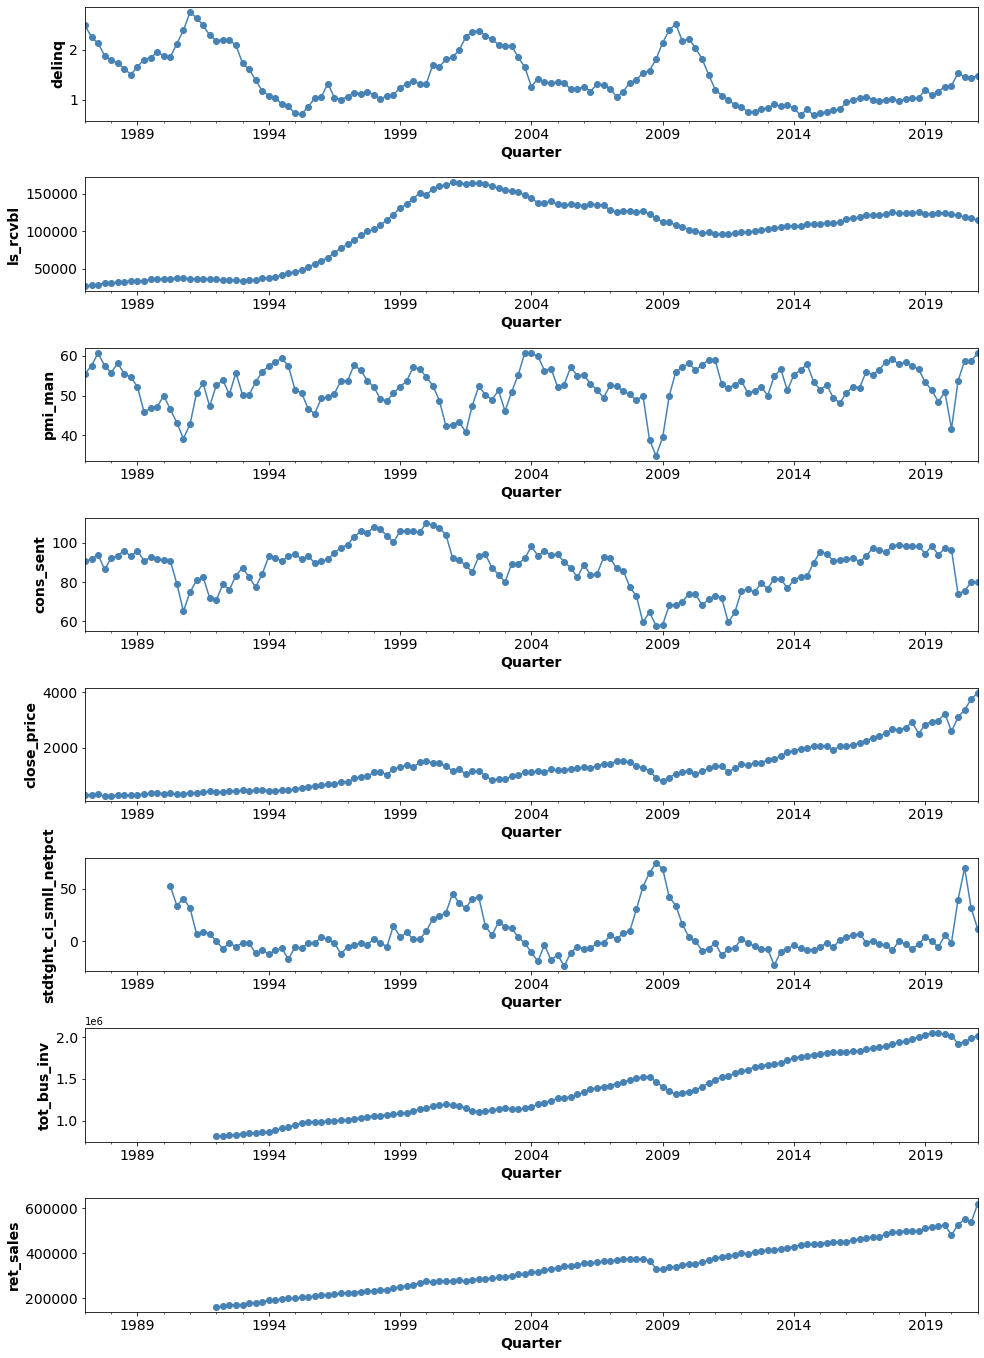

In [6]:
fig01, axes01 = plt.subplots(nrows=n_series,ncols=1,figsize=(16,24))
fig01.subplots_adjust(hspace=0.50)
for i in range(0,n_series):
    #meta data
    col_nm01 = subset_meta[i][0]
    subset_idx01 = subset_meta[i][3]
    
    #line plot
    df_subsets[subset_idx01][col_nm01].plot(ax=axes01[i],style="-o",linewidth=1.5,color='steelblue')
    axes01[i].set_xlabel('Quarter', fontsize = 14.0, fontweight='bold')
    axes01[i].tick_params(axis='x', labelsize=14)
    axes01[i].set_ylabel(col_nm01, fontsize = 14.0, fontweight='bold') 
    axes01[i].tick_params(axis='y', labelsize=14)
    
    #all x axes start at 1987-Q1
    axes01[i].set_xlim(qtr_start[0], axes01[i].get_xlim()[1])
    

### <b>2.4 Natural Log, Difference Time Series</b>
'stdtght_ci_smll_netpct' has negative values, so translate by [ +ABS(MIN('stdtght_ci_smll_netpct')) + 1 ], then log transform and difference

In [7]:
#'stdtght_ci_smll_netpct' translation to handle negative numbers
stdtght_translate = -1*df_full.loc[:,'stdtght_ci_smll_netpct'].min() + 1

#translate, log-e difference, drop NaN
#1987-Q1
df_ln_1987Q1 = np.log(df_subsets[0])
df_lndif01_1987Q1 = df_ln_1987Q1.diff(periods=1,axis=0)
df_lndif01_1987Q1.dropna(axis=0,how='any',inplace=True)

#1990-Q2
df_translate_1990Q2 = df_subsets[1].copy()
df_translate_1990Q2['stdtght_ci_smll_netpct'] = df_translate_1990Q2['stdtght_ci_smll_netpct'] + stdtght_translate
df_ln_1990Q2 = np.log(df_translate_1990Q2)
df_lndif01_1990Q2 = df_ln_1990Q2.diff(periods=1,axis=0)
df_lndif01_1990Q2.dropna(axis=0,how='any',inplace=True)

#1992-Q1
df_translate_1992Q1 = df_subsets[2].copy()
df_translate_1992Q1['stdtght_ci_smll_netpct'] = df_translate_1992Q1['stdtght_ci_smll_netpct'] + stdtght_translate
df_ln_1992Q1 = np.log(df_translate_1992Q1)
df_lndif01_1992Q1 = df_ln_1992Q1.diff(periods=1,axis=0)
df_lndif01_1992Q1.dropna(axis=0,how='any',inplace=True)

#list of dataframe subsets
df_ln_subsets = [df_ln_1987Q1,df_ln_1990Q2,df_ln_1992Q1]
df_lndif01_subsets = [df_lndif01_1987Q1,df_lndif01_1990Q2,df_lndif01_1992Q1]

### <b>2.5 Plot with Basic Stats</b>
Plot natural log differenced series versus time, plot histograms, calculate mean, standard deviation<br><br>
<b>Key Observations</b>
* Transforming and differencing largely removed the trends in each series, although Lease Receivables may still have some trend
* Transforming and differencing also resulted in all variables have a value with a similar scale in terms of magnitude
* As with the original series, fluctations in the trends are notable near the four economic recessions

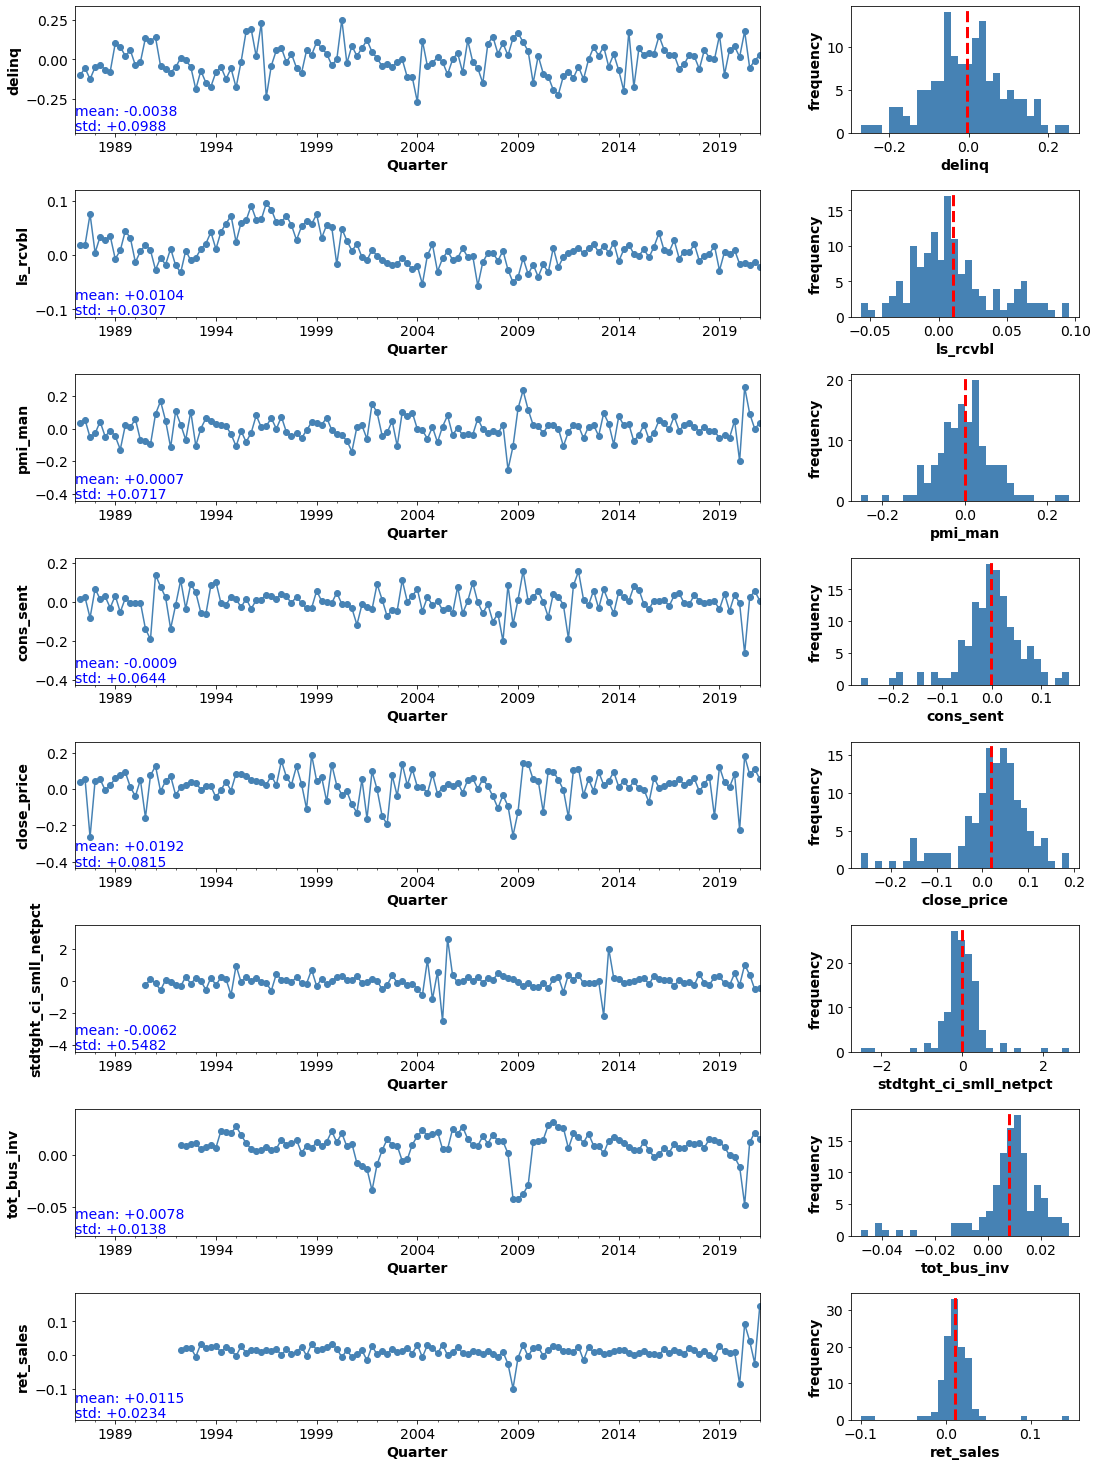

In [8]:
stats_lndif01 = []
fig02, axes02 = plt.subplots(nrows=n_series,ncols=2,figsize=(18,26),gridspec_kw={'width_ratios': [3, 1]})
fig02.subplots_adjust(hspace=0.45)

for i in range(0,n_series):
    #meta data
    col_nm02 = subset_meta[i][0]
    subset_idx02 = subset_meta[i][3]
    
    #basic stats
    stats_lndif01.append(df_lndif01_subsets[subset_idx02][col_nm02].describe())
    mean_text = 'mean: ' + '{:+.4f}'.format(stats_lndif01[i][1])
    std_text = 'std: ' + '{:+.4f}'.format(stats_lndif01[i][2])
    
    #line plot
    df_lndif01_subsets[subset_idx02][col_nm02].plot(ax=axes02[i][0],style="-o",linewidth=1.5,color='steelblue')
    axes02[i][0].set_xlabel('Quarter', fontsize=14.0, fontweight='bold')
    axes02[i][0].tick_params(axis='x', labelsize=14)
    axes02[i][0].set_ylabel(col_nm02, fontsize=14.0, fontweight='bold') 
    axes02[i][0].tick_params(axis='y', labelsize=14)
    
    #all x axes start at 1987-Q1
    axes02[i][0].set_xlim(qtr_start[0], axes02[i][0].get_xlim()[1])
    
    #annotate line plot
    y_lim_rng = axes02[i][0].get_ylim()[1] - axes02[i][0].get_ylim()[0]
    axes02[i][0].set_ylim(axes02[i][0].get_ylim()[0] - 0.30*y_lim_rng,axes02[i][0].get_ylim()[1] + 0.10*y_lim_rng)
    
    x_text = qtr_start[0]
    y_lim_rng = axes02[i][0].get_ylim()[1] - axes02[i][0].get_ylim()[0]
    y_mean = axes02[i][0].get_ylim()[0] + 0.14*y_lim_rng
    y_std = axes02[i][0].get_ylim()[0] + 0.02*y_lim_rng
    axes02[i][0].text(x_text, y_mean, mean_text, fontsize=14.0, color='blue')
    axes02[i][0].text(x_text, y_std, std_text, fontsize=14.0, color='blue')
    
    #histogram plot
    df_lndif01_subsets[subset_idx02][col_nm02].plot(ax=axes02[i][1],kind='hist',bins=30,color='steelblue')
    axes02[i][1].set_xlabel(col_nm02, fontsize=14.0, fontweight='bold')
    axes02[i][1].tick_params(axis='x', labelsize=14)
    axes02[i][1].set_ylabel('frequency', fontsize=14.0, fontweight='bold') 
    axes02[i][1].tick_params(axis='y', labelsize=14) 
    axes02[i][1].axvline(stats_lndif01[i][1], color='r', linestyle='dashed', linewidth=3)

## 3 Time Series - Basic Diagnostics

### <b>3.1 Partial Autocorrelation, Stationarity Test</b>
<b>Key Observations</b>
* Most of the variables show little evidence of autocorrelation (as measured by partial autocorrelation) and non-stationarity (when tested by the KPSS statistic)
* Three variables show some evidence of autocorrelation: Delinquency Rate (lags 1, 2), Lease Receivables (lags 1, 2, 3, 4), Loan Standard Tightening (lag 1), and Business Inventories (lag 1)
* Only 1 variable, Lease Receivables, shows evidence of non-stationarity with KPSS p-value = 0.0306, which is consistency with some evidence of a trend in its time series plot

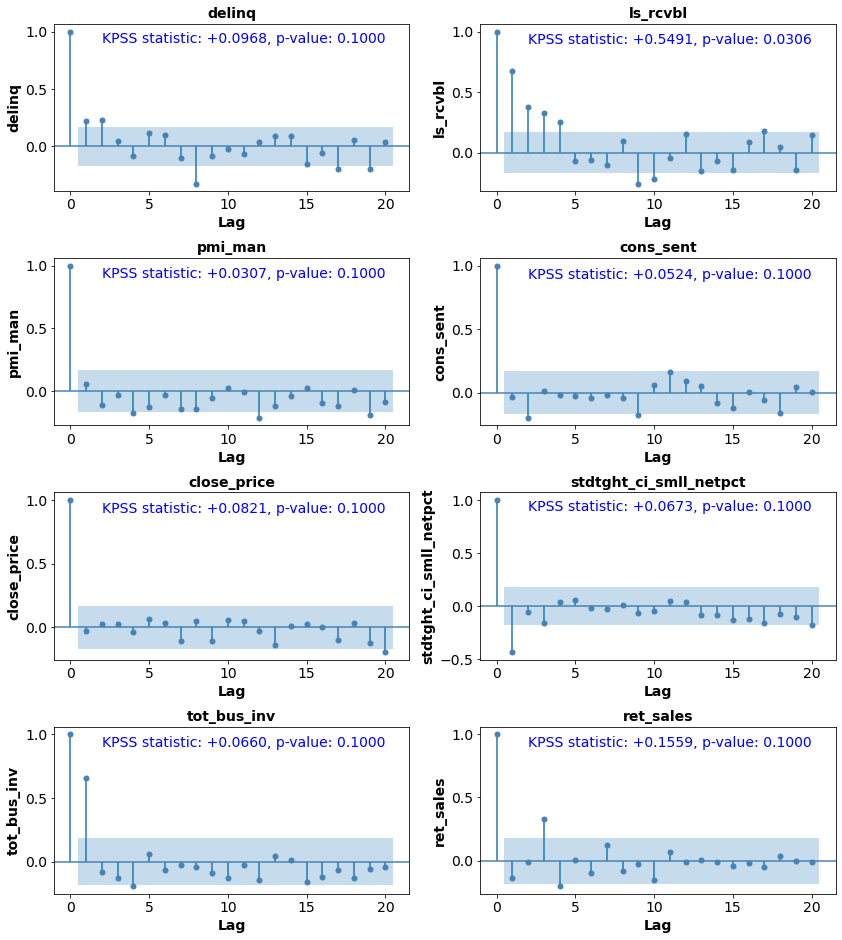

In [9]:
kpss_lndif01 = []
fig03, axes03 = plt.subplots(nrows=int(np.ceil(n_series/2)),ncols=2,figsize=(14,16))
fig03.subplots_adjust(hspace=0.4)
i = -1
for ax0 in axes03.flatten():
    i = i + 1
    if i > (n_series - 1):
        break
    #meta data
    col_nm03 = subset_meta[i][0]
    subset_idx03 = subset_meta[i][3]
    
    #partial autocorrelation
    sm.graphics.tsa.plot_pacf(df_lndif01_subsets[subset_idx03][col_nm03],lags=20,ax=ax0,color='steelblue')
    ax0.set_title(col_nm03, fontsize=14.0, fontweight='bold')
    ax0.set_xlabel('Lag', fontsize = 14.0, fontweight='bold')
    ax0.tick_params(axis='x', labelsize=14)
    ax0.set_ylabel(col_nm03, fontsize=14.0, fontweight='bold') 
    ax0.tick_params(axis='y', labelsize=14)
    
    #kpss test
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        kpss_lndif01.append(sm.tsa.stattools.kpss(df_lndif01_subsets[subset_idx03][col_nm03],nlags='auto'))
    kpss_text = 'KPSS statistic: '+'{:+.4f}'.format(kpss_lndif01[i][0])
    kpss_text = kpss_text + ', p-value: '+'{:.4f}'.format(kpss_lndif01[i][1])
    
    #annotate
    ax0.text(2, 0.9, kpss_text, fontsize=14.0, color='blue')

## 4 Cross-Correlations Among Variables

### <b>4.1 CALCULATE CROSS CORRELATIONS</b>
Correlations are calculated for these two groups of variables:
<ol type="1">
  <li>the relationship between Delinquency Rate and each predictor variable</li>
  <li>the relationship between each pair of predictor variables</li>
</ol> 
For predictor variables, lags from 0 to 10 are analyzed to assess relationships over a range of time lags.

In [10]:
#predictor set, lag set
subset_pred_meta = [s for s in subset_meta if s[1]=='predictor']
lag_set = [0,1,2,3,4,5,6,7,8,9,10]

#loop predictors, loop {response, other predictors}, loop lags, calculate correlation, save results
corr_lndif01_att = []
for x_idx, x_meta in enumerate(subset_pred_meta):
    #x meta data
    x_col_nm0 = x_meta[0]
    x_subset_idx0 = x_meta[3]
    
    for y_idx, y_meta in enumerate(subset_meta):
        #y: response or (predictor not yet looped, y predictor not same as x predictor)
        if (y_meta[1]=='response' or y_idx > x_idx) and x_meta[0] != y_meta[0]:
        
            #y meta data
            y_col_nm0 = y_meta[0]
            y_var_cat0 = y_meta[1]
            y_subset_idx0 = y_meta[3]
    
            for lag_n in lag_set:
                #get x data for lag_n
                x_df_n = df_lndif01_subsets[x_subset_idx0][x_col_nm0].shift(periods=lag_n,axis=0)
                #get y data
                y_df_n = df_lndif01_subsets[y_subset_idx0][y_col_nm0]
                #calculate correlation
                corr_n = x_df_n.corr(y_df_n)
                #save results
                corr_lndif01_att.append([x_col_nm0,y_var_cat0,y_col_nm0,x_subset_idx0,y_subset_idx0,lag_n,corr_n])

#save results in dataframe
df_lndif01_corr = pd.DataFrame(corr_lndif01_att) 
df_lndif01_corr.columns = ['x_var','y_var_cat','y_var','x_subset_idx','y_subset_idx','x_lag','xy_corr']


### <b>4.2 RANK CROSS CORRELATIONS</b>
Correlatons for these two groups of variables are ranked by ABS(correlation):
<ol type="1">
  <li>Top 20 Correlations in the relationship between Delinquency Rate and each predictor variable</li>
  <li>Top 30 Correlations in the relationship between each pair of predictor variables</li>
</ol> 

In [11]:
#calc ABS(xy_corr)
df_lndif01_corr.loc[:,'xy_corr_abs'] = df_lndif01_corr.loc[:,'xy_corr'].abs()

#rank by abs(xy_corr)
df_lndif01_corr.loc[:,'xy_corr_abs_rk'] = df_lndif01_corr.loc[:,'xy_corr_abs'].rank(axis=0,ascending=False)

#rank by abs(xy_corr), by y='delinq' (response) or y!='delinq' (predictor)
is_yvar_resp = df_lndif01_corr['y_var_cat']=='response'
df_lndif01_corr.loc[is_yvar_resp,'xy_corr_ygrp_abs_rk'] = df_lndif01_corr.loc[is_yvar_resp,'xy_corr_abs'].rank(axis=0,ascending=False)
df_lndif01_corr.loc[~is_yvar_resp,'xy_corr_ygrp_abs_rk'] = df_lndif01_corr.loc[~is_yvar_resp,'xy_corr_abs'].rank(axis=0,ascending=False)

#subset top 20 correlations: y=response, plot
topK = 30
is_yvar_resp_topK = is_yvar_resp & (df_lndif01_corr.loc[:,'xy_corr_ygrp_abs_rk']<=topK)

#subset top 30 correlations: y!=response, plot
topK = 30
is_yvar_pred_topK = ~is_yvar_resp & (df_lndif01_corr.loc[:,'xy_corr_ygrp_abs_rk']<=topK)

### <b>4.3 PLOT CROSS CORRELATIONS between PREDICTOR VARIABLES and DELINQUENCY RATE (response variable)</b>
<b>Key Observations</b><br>
* Several variables show a possible relationship with Delinquency Rate, specifically:<br>
<ol type="1">
    <i>Business Inventories</i>
  <li>Lag {0,1}: negative correlation</li>
  <li>Lag {5, 6, 7, 8, 9, 10}: positive correlation</li>
</ol> 
<ol type="1">
<i>PMI</i>
  <li>Lag {1, 3, 6}: negative correlation</li>
</ol> 
<ol type="1">
    <i>Loan Standard Tightening</i>
  <li>Lag {4, 6, 8}: positive correlation</li>
</ol> 
<ol type="1">
    <i>Lease Receivables</i>
  <li>Lag {3, 4, 5, 6, 7, 8, 9, 10}: positive correlation</li>
</ol> 
<br>
* The Top 30 correlations range in magnitude from -0.3786 and +0.3588 to -0.1631 and +0.1460
* Retail Sales also shows correlations with Delinquency Rate, but these correlations may be driven by just 1 or a few data points

(0.0, 1.0, 0.0, 1.0)

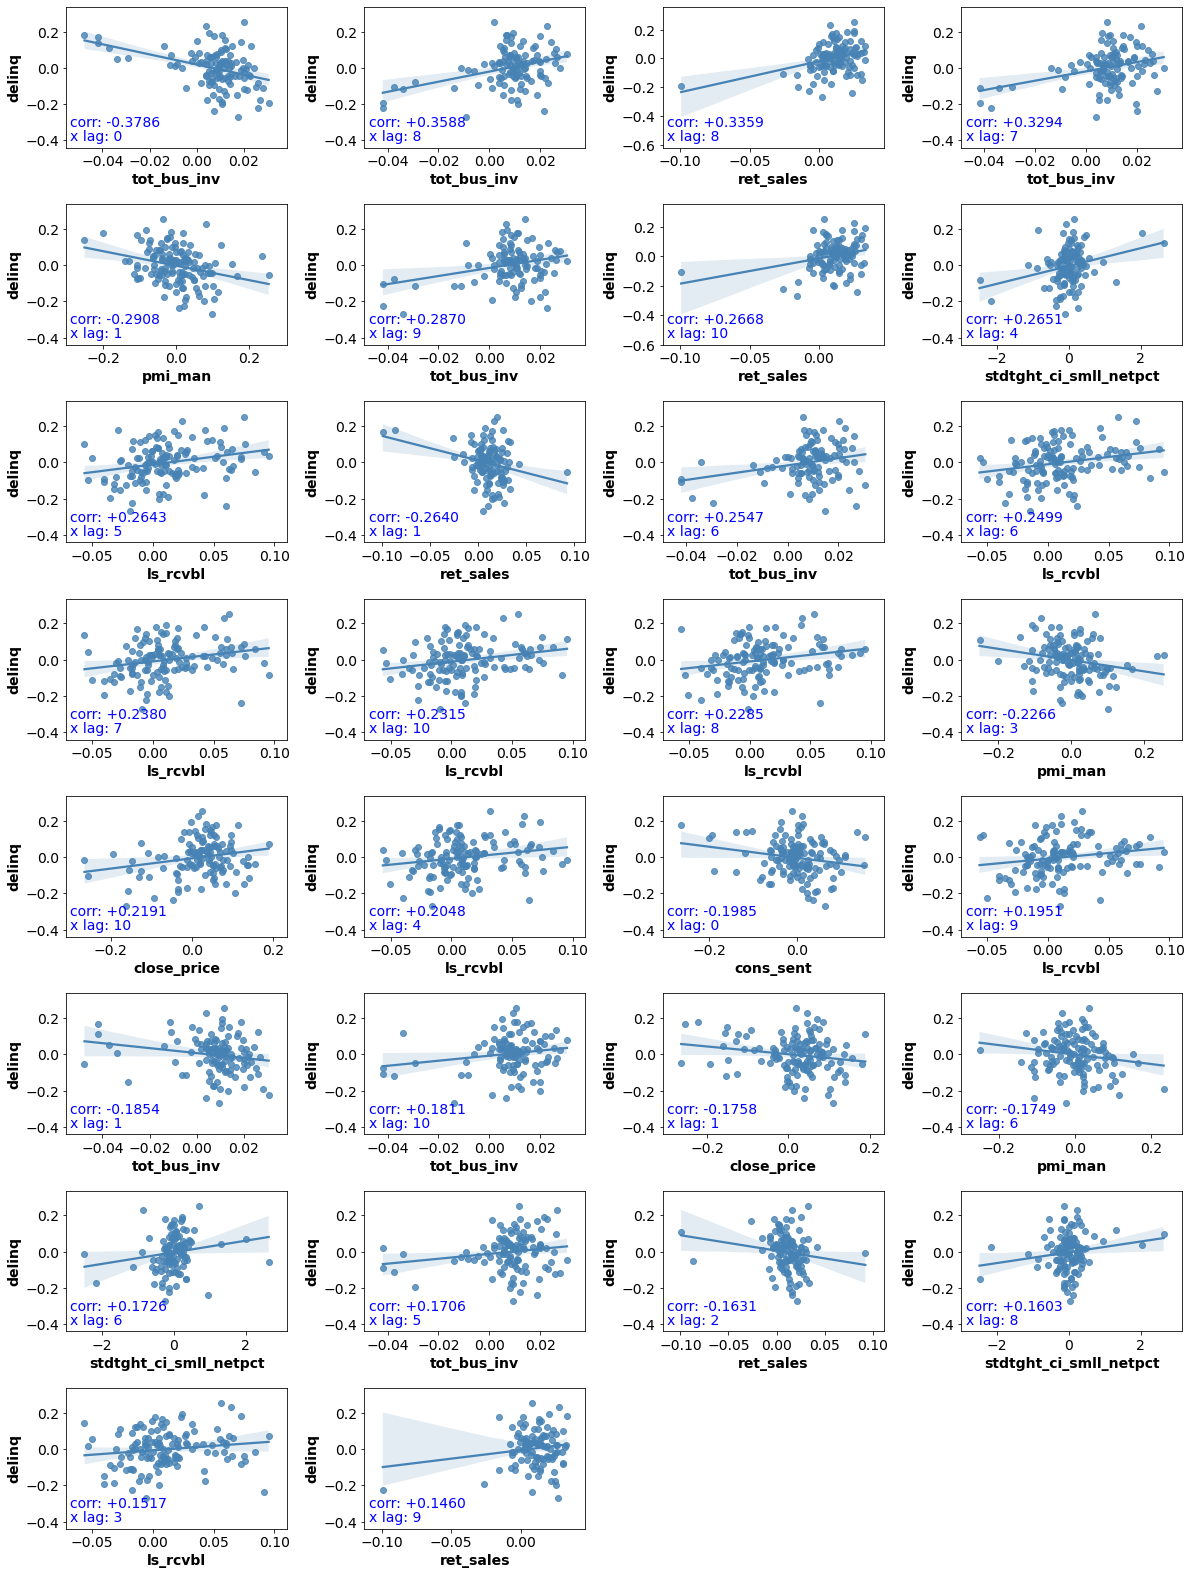

In [12]:
#plt topK correlations with response variable
n_topK = np.sum(is_yvar_resp_topK)

fig04, axes04 = plt.subplots(nrows=int(np.ceil(n_topK/4)),ncols=4,figsize=(20,28))
fig04.subplots_adjust(wspace=0.35, hspace=0.4)
axes04_flt = axes04.flatten()

#loop over topK correlations
ct01 = -1
for idx04, row04 in df_lndif01_corr[is_yvar_resp_topK].sort_values('xy_corr_ygrp_abs_rk').iterrows():
    xy_subset_idx04 = np.max([row04['x_subset_idx'],row04['y_subset_idx']])
    x_col_nm04 = row04['x_var']
    y_col_nm04 = row04['y_var']
    x_lag04 = row04['x_lag']
    xy_corr04 = row04['xy_corr']
    
    #x_data,y_data
    x_data04 = df_lndif01_subsets[xy_subset_idx04][x_col_nm04].shift(periods=x_lag04,axis=0)
    y_data04 = df_lndif01_subsets[xy_subset_idx04][y_col_nm04]
    
    #plot
    ct01 = ct01 + 1
    axes04_n = axes04_flt[ct01]
    sns.regplot(ax=axes04_n,x=x_data04,y=y_data04,color='steelblue')
    axes04_n.set_xlabel(x_col_nm04, fontsize=14.0, fontweight='bold')
    axes04_n.tick_params(axis='x', labelsize=14)
    axes04_n.set_ylabel(y_col_nm04, fontsize=14.0, fontweight='bold')
    axes04_n.tick_params(axis='y', labelsize=14) 
    
    #annotate scatter plot
    x_lim_rng04 = axes04_n.get_xlim()[1] - axes04_n.get_xlim()[0]
    y_lim_rng04 = axes04_n.get_ylim()[1] - axes04_n.get_ylim()[0]
    axes04_n.set_ylim(axes04_n.get_ylim()[0] - 0.25*y_lim_rng04,axes04_n.get_ylim()[1] + 0.10*y_lim_rng04)
    axes04_n.set_xlim(axes04_n.get_xlim()[0] - 0.10*x_lim_rng04,axes04_n.get_xlim()[1] + 0.10*x_lim_rng04)
    
    x_lim_rng04 = axes04_n.get_xlim()[1] - axes04_n.get_xlim()[0]
    y_lim_rng04 = axes04_n.get_ylim()[1] - axes04_n.get_ylim()[0]
    x_text04 = axes04_n.get_xlim()[0] + 0.02*x_lim_rng04
    y_lag04 = axes04_n.get_ylim()[0] + 0.05*y_lim_rng04
    y_corr04 = axes04_n.get_ylim()[0] + 0.15*y_lim_rng04
    
    lag_text04 = 'x lag: ' + '{:d}'.format(x_lag04)
    corr_text04 = 'corr: ' + '{:+.4f}'.format(xy_corr04)

    axes04_n.text(x_text04, y_lag04, lag_text04, fontsize=14.0, color='blue')
    axes04_n.text(x_text04, y_corr04, corr_text04, fontsize=14.0, color='blue')


#remove two unused subplots
ct01 = ct01 + 1
axes04_flt[ct01].axis("off")
ct01 = ct01 + 1
axes04_flt[ct01].axis("off")

### <b>4.4 PLOT CROSS CORRELATIONS between PREDICTOR VARIABLES</b>
<b>Key Observations</b><br>
* Several predictor variables show a possible relationship with each other
* S&P 500 Close Price, Retail Sales, PMI, Business Inventories and Consumer Sentiment are correlated with each over a number of short lag intervals</li>
* Most correlations are positives and occur for short lag periods, only PMI and Business Inventories show a large negative correlation (-0.3688 for lag 0)
* The Top 30 correlations range in magnitude from -0.3688 and +0.5104 to -0.1814 and +0.1742

(0.0, 1.0, 0.0, 1.0)

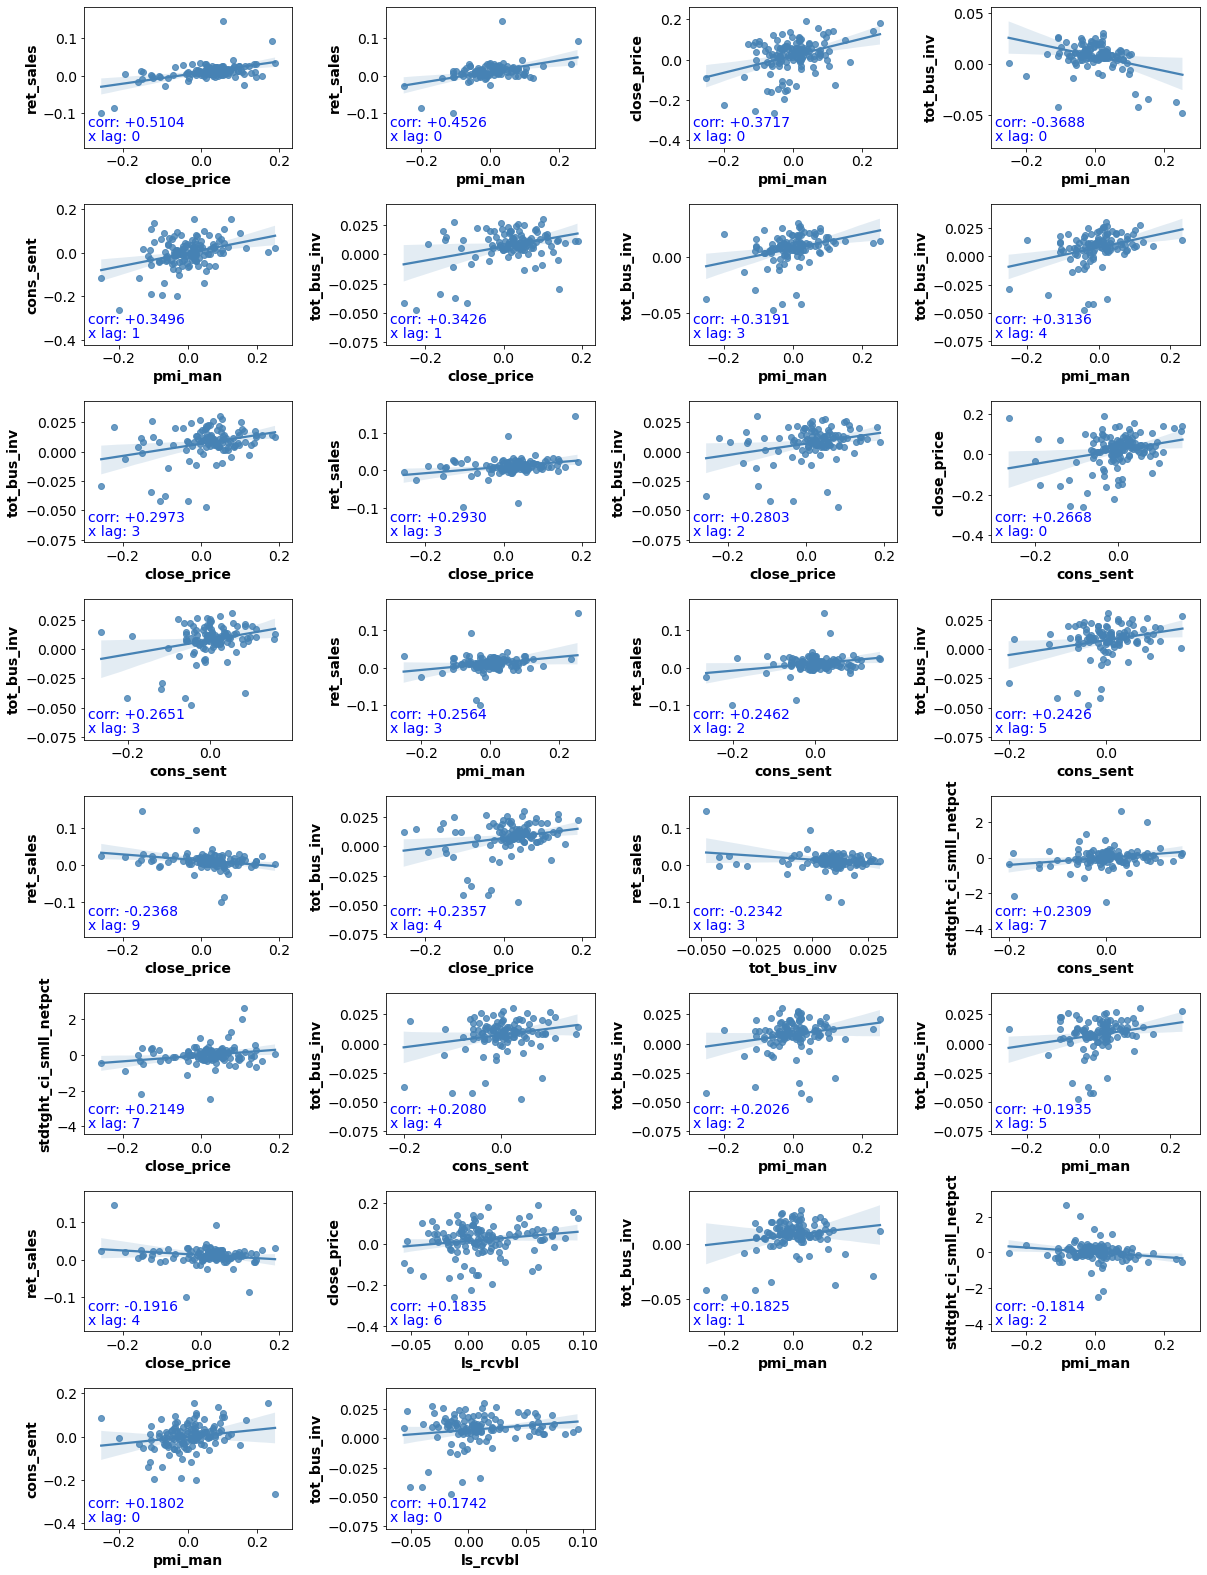

In [13]:
#plt topK correlations with response variable
n_topK = np.sum(is_yvar_pred_topK)

fig05, axes05 = plt.subplots(nrows=int(np.ceil(n_topK/4)),ncols=4,figsize=(20,28))
fig05.subplots_adjust(wspace=0.45, hspace=0.4)
axes05_flt = axes05.flatten()

#loop over topK correlations
ct01 = -1
for idx05, row05 in df_lndif01_corr[is_yvar_pred_topK].sort_values('xy_corr_ygrp_abs_rk').iterrows():
    xy_subset_idx05 = np.max([row05['x_subset_idx'],row05['y_subset_idx']])
    x_col_nm05 = row05['x_var']
    y_col_nm05 = row05['y_var']
    x_lag05 = row05['x_lag']
    xy_corr05 = row05['xy_corr']
    
    #x_data,y_data
    x_data05 = df_lndif01_subsets[xy_subset_idx05][x_col_nm05].shift(periods=x_lag05,axis=0)
    y_data05 = df_lndif01_subsets[xy_subset_idx05][y_col_nm05]
    
    #plot
    ct01 = ct01 + 1
    axes05_n = axes05_flt[ct01]
    sns.regplot(ax=axes05_n,x=x_data05,y=y_data05,color='steelblue')
    axes05_n.set_xlabel(x_col_nm05, fontsize=14.0, fontweight='bold')
    axes05_n.tick_params(axis='x', labelsize=14)
    axes05_n.set_ylabel(y_col_nm05, fontsize=14.0, fontweight='bold')
    axes05_n.tick_params(axis='y', labelsize=14) 
    
    #annotate scatter plot
    x_lim_rng05 = axes05_n.get_xlim()[1] - axes05_n.get_xlim()[0]
    y_lim_rng05 = axes05_n.get_ylim()[1] - axes05_n.get_ylim()[0]
    axes05_n.set_ylim(axes05_n.get_ylim()[0] - 0.30*y_lim_rng05,axes05_n.get_ylim()[1] + 0.10*y_lim_rng05)
    axes05_n.set_xlim(axes05_n.get_xlim()[0] - 0.10*x_lim_rng05,axes05_n.get_xlim()[1] + 0.10*x_lim_rng05)
    
    x_lim_rng05 = axes05_n.get_xlim()[1] - axes05_n.get_xlim()[0]
    y_lim_rng05 = axes05_n.get_ylim()[1] - axes05_n.get_ylim()[0]
    x_text05 = axes05_n.get_xlim()[0] + 0.02*x_lim_rng05
    y_lag05 = axes05_n.get_ylim()[0] + 0.05*y_lim_rng05
    y_corr05 = axes05_n.get_ylim()[0] + 0.15*y_lim_rng05
    
    lag_text05 = 'x lag: ' + '{:d}'.format(x_lag05)
    corr_text05 = 'corr: ' + '{:+.4f}'.format(xy_corr05)

    axes05_n.text(x_text05, y_lag05, lag_text05, fontsize=14.0, color='blue')
    axes05_n.text(x_text05, y_corr05, corr_text05, fontsize=14.0, color='blue')

    
#remove two unused subplots
ct01 = ct01 + 1
axes05_flt[ct01].axis("off")
ct01 = ct01 + 1
axes05_flt[ct01].axis("off")

### <b>4.5 PLOT CROSS CORRELATIONS with DELINQUENCY RATE (response variable) by LAG</b>
<b>Key Observations</b>
* The below plots show another view of correlations between predictor variables and Delinquency Rate
* Plot are sorted in descending order by the MAX(ABS(Correlation)) over lags for each predictor, with Business Inventories showing both the largest MAX absolute value correlation and largest MEAN absolute value correlation, peaking at lag 8
* MAX correlation is closely related to MEAN correlation, except for Lease Receivables which shows relatively high MEAN correlation relative to its MAX correlation

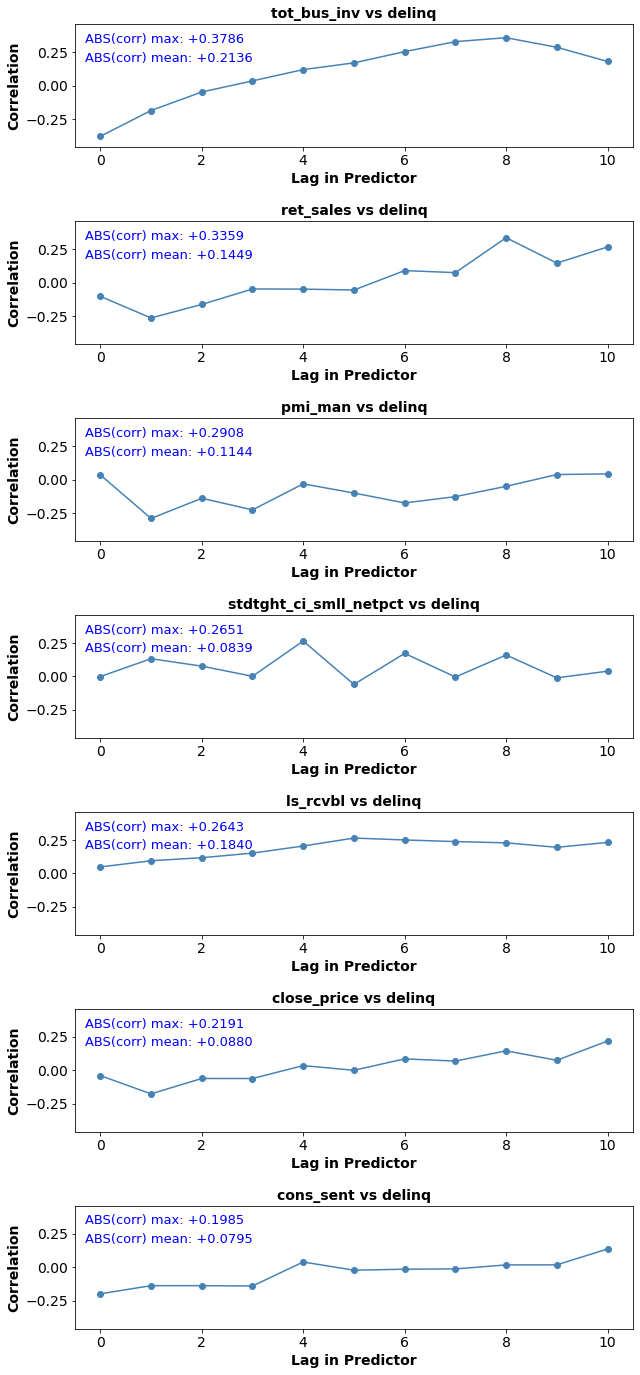

In [14]:
#line plot: predictor vs response - corr vs lag, series by x_var
df_lndif01_corr_absagg_xvar = df_lndif01_corr.loc[is_yvar_resp,:].groupby('x_var')[['xy_corr_abs']].agg(['max','mean']).sort_values(by=('xy_corr_abs','max'),ascending=False)
df_lndif01_corr_absagg_xvar.columns = ['_'.join(col) for col in df_lndif01_corr_absagg_xvar.columns.values]
n_xvar = df_lndif01_corr_absagg_xvar.shape[0]

fig06, axes06 = plt.subplots(nrows=n_xvar,ncols=1,figsize=(10,24))
fig06.subplots_adjust(hspace=0.6)
ct01 = -1
for idx06, row06 in df_lndif01_corr_absagg_xvar.iterrows():
    #x_var,y_var
    x_col_nm06 = idx06
    is_xyvars_resp = is_yvar_resp & (df_lndif01_corr.loc[:,'x_var']==x_col_nm06)
    #x_data,y_data
    x_data06 = 'x_lag'
    y_data06 = 'xy_corr'
    
    #line plot
    ct01 = ct01 + 1
    df_lndif01_corr.loc[is_xyvars_resp,:].plot(ax=axes06[ct01],x=x_data06,y=y_data06,style="-o",linewidth=1.5,color='steelblue')
    axes06[ct01].set_title(x_col_nm06 + ' vs delinq', fontsize = 14.0, fontweight='bold')
    axes06[ct01].set_xlabel('Lag in Predictor', fontsize = 14.0, fontweight='bold')
    axes06[ct01].tick_params(axis='x', labelsize=14)
    axes06[ct01].set_ylabel('Correlation', fontsize = 14.0, fontweight='bold') 
    axes06[ct01].tick_params(axis='y', labelsize=14)
    
    axes06[ct01].set_ylim(-0.46,+0.46)
    axes06[ct01].get_legend().remove()
    
    #annotate
    corr_max06 = df_lndif01_corr_absagg_xvar.loc[x_col_nm06,'xy_corr_abs_max']
    corr_mean06 = df_lndif01_corr_absagg_xvar.loc[x_col_nm06,'xy_corr_abs_mean']
    corr_max_text06 = 'ABS(corr) max: ' + '{:+.4f}'.format(corr_max06)
    corr_mean_text06 = 'ABS(corr) mean: ' + '{:+.4f}'.format(corr_mean06)
    
    x_text06 = -0.30
    y_corr_max06 = 0.32
    y_corr_mean06 = 0.18

    axes06[ct01].text(x_text06, y_corr_max06, corr_max_text06, fontsize=13.0, color='blue')
    axes06[ct01].text(x_text06, y_corr_mean06, corr_mean_text06, fontsize=13.0, color='blue')
    

## 6 Conclusions
<b>SAVE DATA TO PYTHON-NATIVE PICKLE FILE<b>

In [15]:
import pickle
filnm01 = '../data/delinq_transformed_subsets.pkl'

data_objects = [subset_meta, row_subsets, df_subsets, df_ln_subsets, df_lndif01_subsets]
with open(filnm01, "wb") as f:
    pickle.dump(data_objects, f)


<b>KEY RESULTS</b>

The key results of this exploratory data analysis are:
<ol type="1">
  <li>Natural log transforming and differencing the time series largely results in staionary series</li>
  <li>Some times series show some autocorrelation over short lag intervals</li>
  <li>By examining both plots and correlation values, there appears to be some correlation structure in the data among the variables</li>
  <li>There are both negative and positive correlations between Delinquency Rate and several predictor variables, and there is evidence of positive correlations with lags up to 2 years whereas the largest negative correlations are for shorter lag periods</li>
  <li>There is also evidence for correlations between predictor variables, with most correlations positive and ocurring over shorter lag periods</li>
  <li>Overall, there is evidence of correlation structure in the data that might be used to understand and predict Lease Delinquency Rate</li>
</ol> 